<a href="https://colab.research.google.com/github/spiyer99/fastbook_sols/blob/master/18_CAM_sols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#hide
!pip install -q fastbook
import fastbook
# fastbook.setup_book()

     |████████████████████████████████| 727kB 4.5MB/s 
     |████████████████████████████████| 194kB 9.3MB/s 
     |████████████████████████████████| 51kB 3.5MB/s 
     |████████████████████████████████| 1.2MB 10.1MB/s 
     |████████████████████████████████| 12.8MB 20.1MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [ ]:
#hide
from fastbook import *

## Questionnaire

__1. What is a "hook" in PyTorch?__

They are very similar to fastai's callbacks. However, with a hook you can modify the code for the forward and backward calucations. 

__2. Which layer does CAM use the outputs of?__

The last conv layer

__3. Why does CAM require a hook?__

Because we need to store the activations of the last layer. This can be done with a hook.

__4. Look at the source code of the `ActivationStats` class and see how it uses hooks.__

__5. Write a hook that stores the activations of a given layer in a model (without peeking, if possible).__

In [ ]:
class ActivationsStore(HookCallback):
  def __init__(self): 
    super().__init__()
  def hook_func(self, m, i, o):
    self.stored = o.detach().clone()

__6. Why do we call `eval` before getting the activations? Why do we use `no_grad`?__



In [ ]:
path = untar_data(URLs.PETS)/'images'
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=21,
    label_func=is_cat, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
# learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
!wget https://storage.googleapis.com/pr-newsroom-wp/1/2020/05/IMG_1874-copy-1.jpg # joe rogan

--2021-04-19 06:45:16--  https://storage.googleapis.com/pr-newsroom-wp/1/2020/05/IMG_1874-copy-1.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1098530 (1.0M) [image/jpeg]
Saving to: ‘IMG_1874-copy-1.jpg’

IMG_1874-copy-1.jpg 100%[===================>]   1.05M  --.-KB/s    in 0.008s  

2021-04-19 06:45:16 (124 MB/s) - ‘IMG_1874-copy-1.jpg’ saved [1098530/1098530]



In [ ]:
img = PILImage.create('IMG_1874-copy-1.jpg')
x, = first(dls.test_dl([img]))

In [ ]:
hook_output = ActivationsStore()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [ ]:
with torch.no_grad(): 
  output = learn.model.eval()(x)

In [ ]:
output

tensor([[ 4.7868, -0.1780]])

[`learn.model.eval()`](https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch#:~:text=eval()%20is%20a%20kind,will%20do%20it%20for%20you): Sets up the model for inference. (Eg. turns off batchnorm layers, dropout layers, etc.).

[`torch.no_grad`](https://stackoverflow.com/questions/63351268/torch-no-grad-affects-on-model-accuracy#:~:text=1-,torch.,to%20later%20calculate%20a%20gradient.&text=Up%20vote%201-,torch.,weight%20in%20the%20specified%20layers): This disables the tracking of calculations required to calculate the gradient. Reduces runtime and saves memory.


__7. Use `torch.einsum` to compute the "dog" or "cat" score of each of the locations in the last activation of the body of the model.__



In [ ]:
act = hook_output.stored[0]
len(act), act.shape

(512, torch.Size([512, 7, 7]))

In [ ]:
F.softmax(output, dim=-1)

tensor([[0.9931, 0.0069]])

In [ ]:
dls.vocab

[False, True]

Therefore this is highly likely to be a dog

In [ ]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 7, 7])

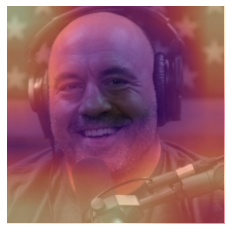

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma')

__8. How do you check which order the categories are in (i.e., the correspondence of index->category)?__

We can use `dls.vocab` to check the classes.

In [ ]:
dls.vocab

[False, True]

index `0` is a Dog. index `1` is a Cat.

__9. Why are we using `decode` when displaying the input image?__

We have to denormalize the data

In [ ]:
dls.train.decode((x,))[0][0]

TensorImage([[[13, 17, 11,  ..., 48, 34, 25],
         [14, 16, 13,  ..., 50, 38, 28],
         [13, 16, 14,  ..., 55, 41, 31],
         ...,
         [22, 20, 18,  ..., 16, 20, 16],
         [17, 18, 18,  ..., 18, 16, 12],
         [18, 17, 17,  ..., 19, 17, 13]],

        [[14, 17, 12,  ..., 57, 41, 28],
         [14, 16, 13,  ..., 59, 45, 33],
         [14, 16, 15,  ..., 64, 49, 37],
         ...,
         [27, 23, 21,  ..., 23, 25, 21],
         [22, 22, 22,  ..., 23, 21, 16],
         [22, 21, 21,  ..., 24, 22, 16]],

        [[19, 23, 18,  ..., 60, 44, 34],
         [20, 22, 20,  ..., 62, 49, 37],
         [21, 23, 22,  ..., 67, 52, 39],
         ...,
         [37, 30, 27,  ..., 29, 32, 27],
         [30, 29, 28,  ..., 30, 27, 21],
         [32, 29, 27,  ..., 30, 28, 21]]])

In [ ]:
dls.train.decode((x,))[0][0].shape

torch.Size([3, 224, 224])

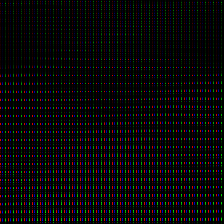

In [ ]:
to_image(dls.train.decode((x,))[0][0])

In [ ]:
act_map_img = cam_map[1].detach().cpu()
act_map_img = act_map_img[None, :]
act_map_img.shape

torch.Size([1, 7, 7])

In [ ]:
t = torch.zeros(3, *act_map_img.shape[1:]) # 3 channels (for RGB)
t.shape

torch.Size([3, 7, 7])

In [ ]:
t1 = (act_map_img + t) # broadcasting
t1.shape

torch.Size([3, 7, 7])

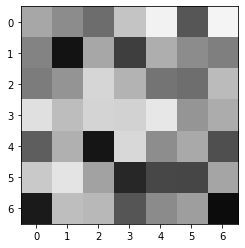

In [ ]:
img = to_image(t1)
plt.imshow(img)

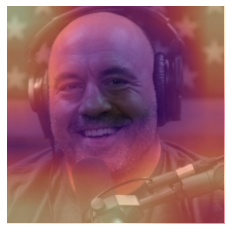

In [ ]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma')

__10. What is a "context manager"? What special methods need to be defined to create one?__

It's a python construct that calls `__enter__` and `__exit__`. We have to define the enter and exit methods to use this.

__11. Why can't we use plain CAM for the inner layers of a network?__

We need to get the gradients of each layer. These are not stored with plain CAM.



__12. Why do we need to register a hook on the backward pass in order to do Grad-CAM?__

In order to store the gradients.

__13. Why can't we call `output.backward()` when `output` is a rank-2 tensor of output activations per image per class?__



In [ ]:
class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
# cls = 1
# with HookBwd(learn.model[0]) as hookg:
#     with Hook(learn.model[0]) as hook:
#         output = learn.model.eval()(x)
#         act = hook.stored
#     output.backward()
#     # output[0,cls].backward()
#     grad = hookg.stored

The gradient can only be created for scalar outputs. We have to chose the first image (index 0) and the second class (index 1) in order to run backward and get the gradients.

In [ ]:
cls = 1
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
    # output.backward()
    output[0,cls].backward()
    grad = hookg.stored

In [ ]:
grad.shape

torch.Size([1, 512, 7, 7])

In [ ]:
act.shape

torch.Size([1, 512, 7, 7])

## Further Research

__1. Try removing keepdim and see what happens. Look up this parameter in the PyTorch docs. Why do we need it in this notebook?__

In [ ]:
w = grad[0].mean(dim=[1,2] , keepdim = True)
w.shape

torch.Size([512, 1, 1])

In [ ]:
w1 = grad[0].mean(dim=[1,2])
w1.shape

torch.Size([512])

In [ ]:
torch.squeeze(w).shape

torch.Size([512])

`keepdim = False` appears to run `torch.squeeze` on the result. This removes all places where `dimension == 1`.

__2. Create a notebook like this one, but for NLP, and use it to find which words in a movie review are most significant in assessing the sentiment of a particular movie review.__

In [ ]:
from fastai.text.all import *

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
dls = TextDataLoaders.from_df(df, path=path, text_col='text', label_col='label', valid_col='is_valid')
learn = text_classifier_learner(dls, AWD_LSTM)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dls.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,time
0,0.594509,0.628708,04:44


In [ ]:
x,y = first(dls.train_ds)
x.shape

torch.Size([108])

In [ ]:
x[None, :].shape

torch.Size([1, 108])

In [ ]:
t = torch.zeros(32, x[None, :].shape[-1])
t.shape

torch.Size([32, 108])

In [ ]:
x = x + t
x = x.long()
x.shape

torch.Size([32, 108])

In [ ]:
class HookBwd_lm():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): 
      print(go[0])
      self.stored = go[0].detach().clone()
      print(self.stored)
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
class Hook_lm():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): 
      # print(o[0].shape)
      # print(o[0])
      # print(o[1].shape)
      # print(o[1])
      # self.stored = o[0].detach().clone()
      self.stored = o[0].clone().detach().requires_grad_(True)
      # print(self.stored)
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [ ]:
cls = 1
dls.vocab[1][cls]

'positive'

In [ ]:
text = 'top gear episode 1'
learn.model.train()
learn.model.zero_grad()
learn.model.reset()

In [ ]:
x, = first(learn.dls.test_dl([text]))
x

TensorText([[  2, 349,   0, 387, 329]])

In [ ]:
with HookBwd_lm(learn.model[0]) as hookg:
    with Hook_lm(learn.model[0]) as hook:
        output = learn.model.eval()(x)
        act = hook.stored
        print(act)
    # output[0][1,cls].backward()
    output[0][0][cls].backward()
    grad = hookg.stored

TensorText([[[ 0.1275,  0.0029,  0.0113,  ..., -0.0193,  0.0351,  0.0011],
         [ 0.4133,  0.0472,  0.0298,  ..., -0.1688, -0.3644,  0.3846],
         [ 0.1097,  0.4288,  0.2149,  ...,  0.3352, -0.2172,  0.3383],
         [ 0.0031,  0.2255,  0.0519,  ...,  0.1632, -0.3436,  0.1751],
         [ 0.0056,  0.0083, -0.1565,  ...,  0.0324, -0.3085, -0.0663]]], requires_grad=True)


AttributeError: ignored

#fastai v1

In [ ]:
text = 'top gear episode 1'
class_id = None
learn.model.train()
# _eval_dropouts(learn.model)
learn.model.zero_grad()
learn.model.reset()

In [ ]:
dl = learn.dls.test_dl([text])
batch = next(iter(dl))[0]
emb = learn.model[0].module.encoder(batch).detach().requires_grad_(True)
emb.retain_grad()
lstm = learn.model[0].module(emb, True)
learn.model.eval()

SequentialRNN(
  (0): SentenceEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(7080, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(7080, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): LinBnDrop(
        (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=1200, out_features=50, bias=False)
        (3): ReLU(inplace=True)


In [ ]:
cl = learn.model[1]((lstm, torch.zeros_like(batch).bool(),))[0].softmax(dim=-1)
cl

tensor([[0.6166, 0.3834]], grad_fn=<SoftmaxBackward>)

In [ ]:
if class_id is None: class_id = cl.argmax()
class_id

tensor(0)

In [ ]:
print(cl[0][class_id])
cl[0][class_id].backward()

tensor(0.6166, grad_fn=<SelectBackward>)


In [ ]:
attn = emb.grad.squeeze().abs().sum(dim=-1)
attn /= attn.max()
attn

TensorText([1.0000, 0.6833, 0.4883, 0.5678, 0.3312])

In [ ]:
tok, _ = learn.dls.decode_batch((*tuplify(batch), *tuplify(cl)))[0]
tok

'xxbos top xxunk episode 1'